In [22]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
import seaborn as sns

In [23]:
# Importing data
coffee = yf.Ticker('KC=F')
coffee_data = yf.download('KC=F', start='2010-01-01', end='2025-01-26')

# Calculate daily price change as a percentage
coffee_data['Price Change'] = coffee_data['Close'].pct_change()
# Fill missing values (e.g., for the first row) with 0 or NaN as appropriate
coffee_data['Price Change'].fillna(0, inplace=True)

coffee_data.head()

[*********************100%***********************]  1 of 1 completed
/var/folders/0v/nd2019hd3lxb6r07g9ywbv500000gn/T/ipykernel_1937/464887490.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee_data['Price Change'].fillna(0, inplace=True)


Price,Adj Close,Close,High,Low,Open,Volume,Price Change
Ticker,KC=F,KC=F,KC=F,KC=F,KC=F,KC=F,
Date,,,,,,,
2010-01-04 00:00:00+00:00,141.850006,141.850006,142.449997,136.000000,136.000000,14005,NaN
2010-01-05 00:00:00+00:00,141.000000,141.000000,142.699997,140.399994,141.850006,9109,-0.005992
2010-01-06 00:00:00+00:00,141.600006,141.600006,142.649994,140.050003,141.600006,9547,0.004255
2010-01-07 00:00:00+00:00,141.899994,141.899994,142.399994,139.850006,141.550003,7353,0.002119
2010-01-08 00:00:00+00:00,145.350006,145.350006,146.000000,141.949997,142.449997,16035,0.024313


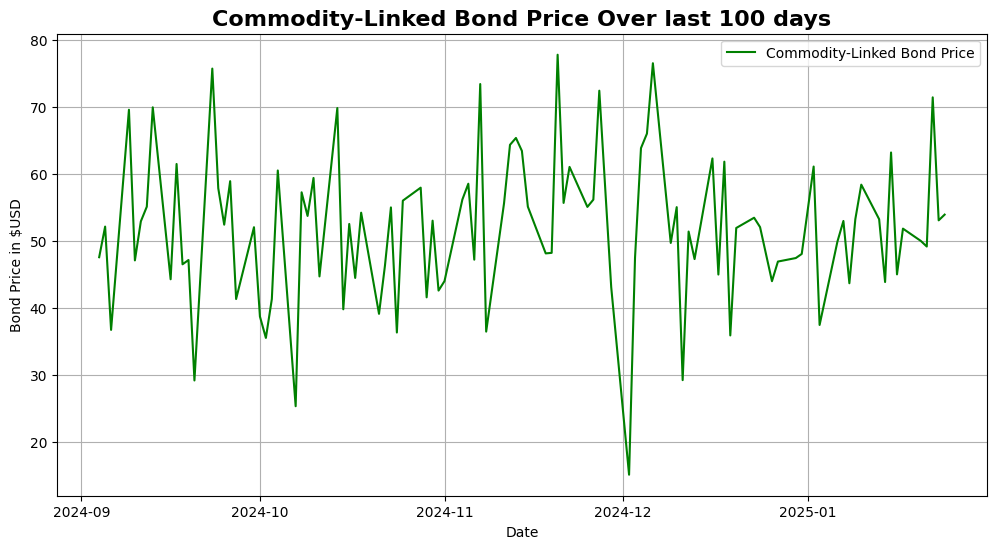

Price                           Close Price Change Bond Price
Ticker                           KC=F                        
Date                                                         
2025-01-20 00:00:00+00:00  328.350006     0.000000  50.000000
2025-01-21 00:00:00+00:00  327.799988    -0.001675  49.162451
2025-01-22 00:00:00+00:00  341.850006     0.042862  71.430779
2025-01-23 00:00:00+00:00  343.950012     0.006143  53.071531
2025-01-24 00:00:00+00:00  346.649994     0.007850  53.924962

The bond price for a $1000.00 bond with 5.00% annual return (today: 2025-01-24) is $53.92$.


In [24]:
# Scenario 1: Conservative investor

# Selected product: Commodity-Linked Bond
fixed_coupon = 0.05 # Fixed component
sensitivity = 0.5 # Sensitivity to commodity price changes
face_value = 1000    # Bond face value (example)

# Function to calculate bond price
def calculate_bond_price(fixed_coupon, sensitivity, price_change, face_value):
    P_f = fixed_coupon * face_value
    delta_C = price_change * face_value
    return P_f + sensitivity * delta_C

# Adding bond price to the dataset
coffee_data['Bond Price'] = coffee_data['Price Change'].apply(
    lambda change: calculate_bond_price(fixed_coupon, sensitivity, change, face_value)
)

# Plotting the bond price over time
plt.figure(figsize=(12, 6))
plt.plot(coffee_data.index[-100:], coffee_data['Bond Price'].iloc[-100:], label='Commodity-Linked Bond Price', color='green')
plt.title('Commodity-Linked Bond Price Over last 100 days', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Bond Price in $USD')
plt.legend()
plt.grid()
plt.show()

# Displaying the data
print(coffee_data[['Close', 'Price Change', 'Bond Price']].tail())

print(f'\nThe bond price for a ${face_value:.2f} bond with {fixed_coupon*100:.2f}% annual return (today: {coffee_data.index[-1].date()}) is ${coffee_data["Bond Price"].iloc[-1]:.2f}$.')

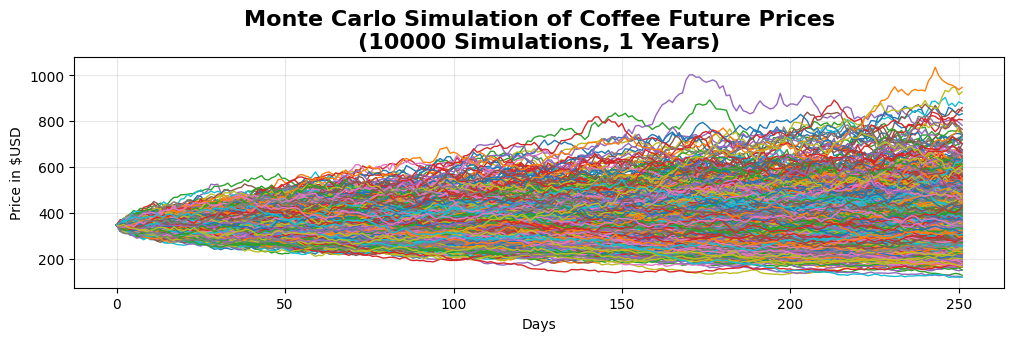

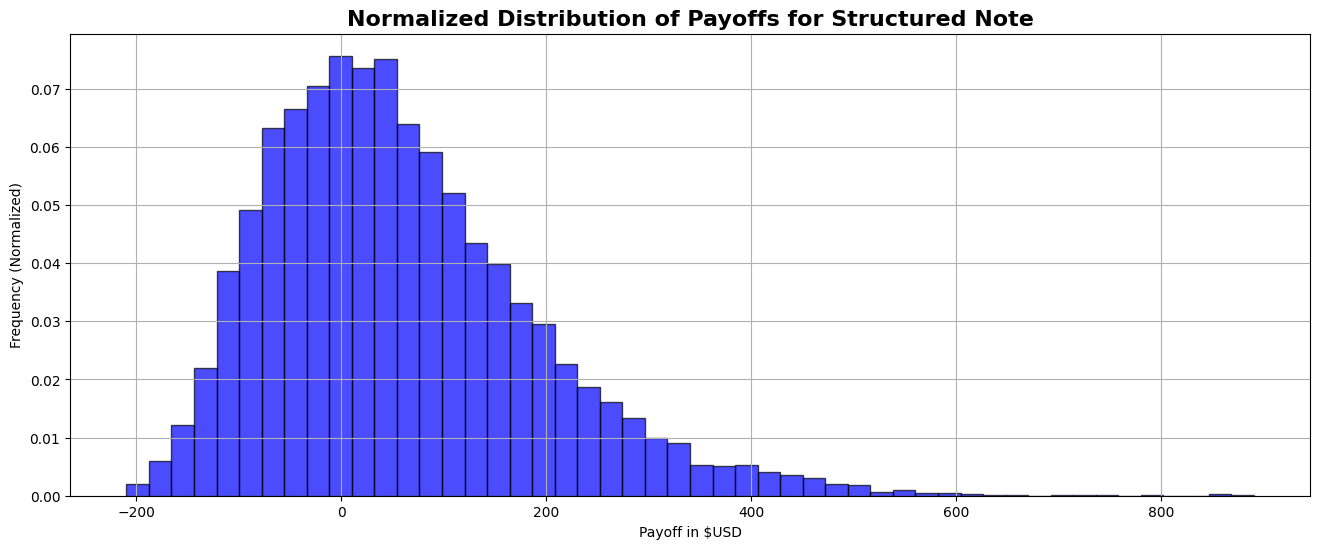

Initial Coffee Price on 2025-01-24: C_0 = $346.65 
Expected Payoff for Structured Note in 1 years: $58.12


In [25]:
# Scenario 2: Moderate Risk Taker

# Selected product: Structured Notes

# Relevant parameters:
C_0 = (coffee_data['Close'].iloc[-1]).iloc[0] # Initial price, here spot price
F = 0.05 * C_0 # Fixed component (5% return)
r = 0.02 # Risk-free rate (2%)
alpha = 1 # Participation rate
daily_returns = coffee_data['Close'].pct_change() # Daily returns of coffee
sigma = (daily_returns.std() * np.sqrt(252)).iloc[0] # Annualized volatility of coffee
mu = (daily_returns.mean() * 252).iloc[0] # Annualized drift of coffee
T = 1 # Simulated period (in years)
num_sims = 10000 # Number of simulations
num_steps = 252 # Number of steps in each simulation (daily)

# Simulating future prices
def MonteCarlo(C_0, mu, sigma, T, num_sims, num_steps):
    np.random.seed(42)  # Set seed for reproducibility
    dt = T / num_steps  # Time increment
    price_paths = np.zeros((num_steps, num_sims))  # Initialize price paths array
    price_paths[0] = C_0  # Set the initial price for all simulations
    
    for t in range(1, num_steps):
        z = np.random.standard_normal(num_sims)  # Generate random normal variables
        price_paths[t] = price_paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    
    return price_paths  # Return the prices at maturity (final time step)

C_T = MonteCarlo(C_0, mu, sigma, T, num_sims, num_steps)

# Plotting the Monte Carlo simulation (1 every 10 simulations)
plt.figure(figsize=(12, 3))
for i in range(0, num_sims, 10):  # Plot 1 every 10 simulations
    plt.plot(C_T[:, i], linewidth=1)
plt.title(f"Monte Carlo Simulation of Coffee Future Prices\n({num_sims} Simulations, {T} Years)", fontsize=16, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Price in $USD")
plt.grid(alpha=0.3)
plt.show()

# Calculate payoff for each simulation
P_n = F + alpha * (C_T[-1] - C_0)

# Expected payoff
expected_payoff = np.mean(P_n)

# Histogram Calculation
counts, bins = np.histogram(P_n, bins=50)  # Raw counts and bin edges
normalized_counts = counts / num_sims  # Normalize frequencies to sum to 1
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting

# Plot the normalized distribution of payoffs
plt.figure(figsize=(16, 6))
plt.bar(bin_centers, normalized_counts, width=np.diff(bins), color='blue', alpha=0.7, edgecolor='black')
plt.title('Normalized Distribution of Payoffs for Structured Note', fontsize=16, fontweight='bold')
plt.xlabel('Payoff in $USD')
plt.ylabel('Frequency (Normalized)')
plt.grid()
plt.show()

# Display results
print(f"Initial Coffee Price on {coffee_data.index[-1].date()}: C_0 = ${C_0:.2f} ")
print(f"Expected Payoff for Structured Note in {T} years: ${expected_payoff:.2f}")


Digital Call Option Value: $0.38
Digital Put Option Value: $0.61
Parameters:
  Initial Price: $346.65
  Strike Price: $363.98
  Reward: $1.00
  Risk-free Rate: 2.00%
  Time to Maturity: 0.5 years
  Volatility: 33.25%


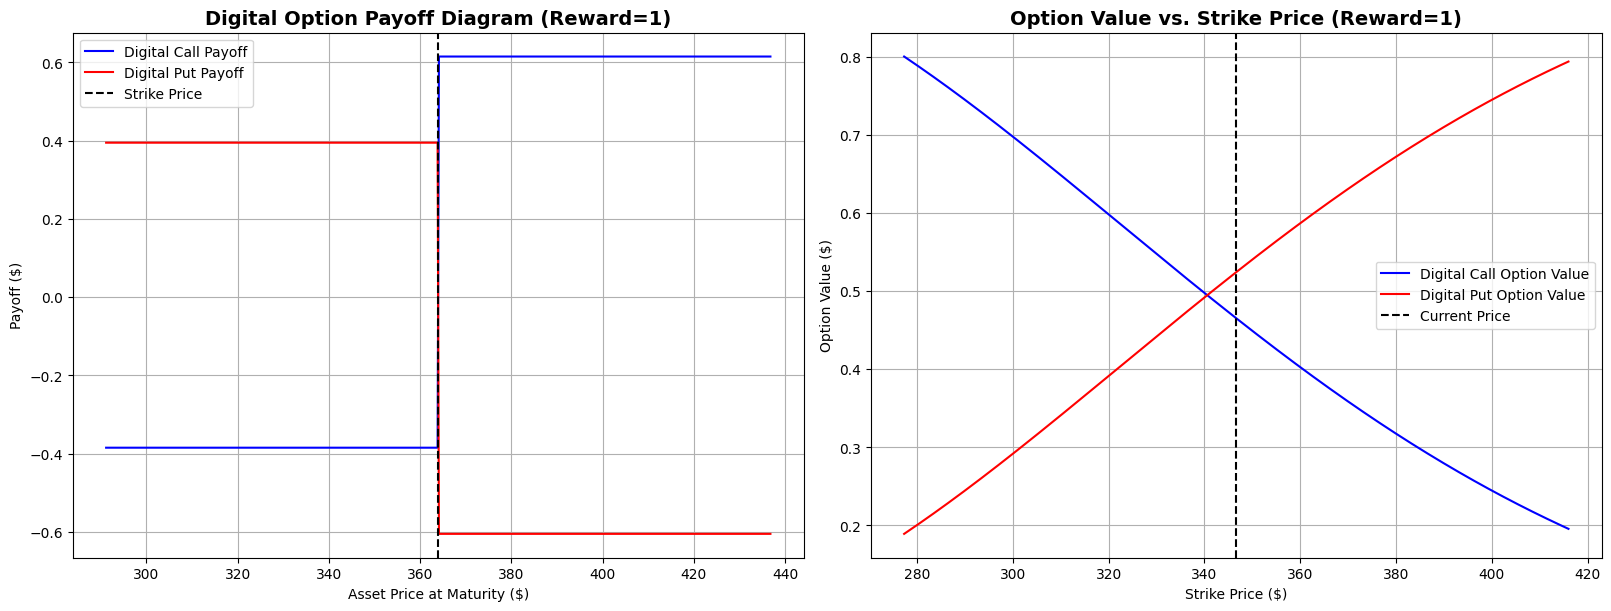

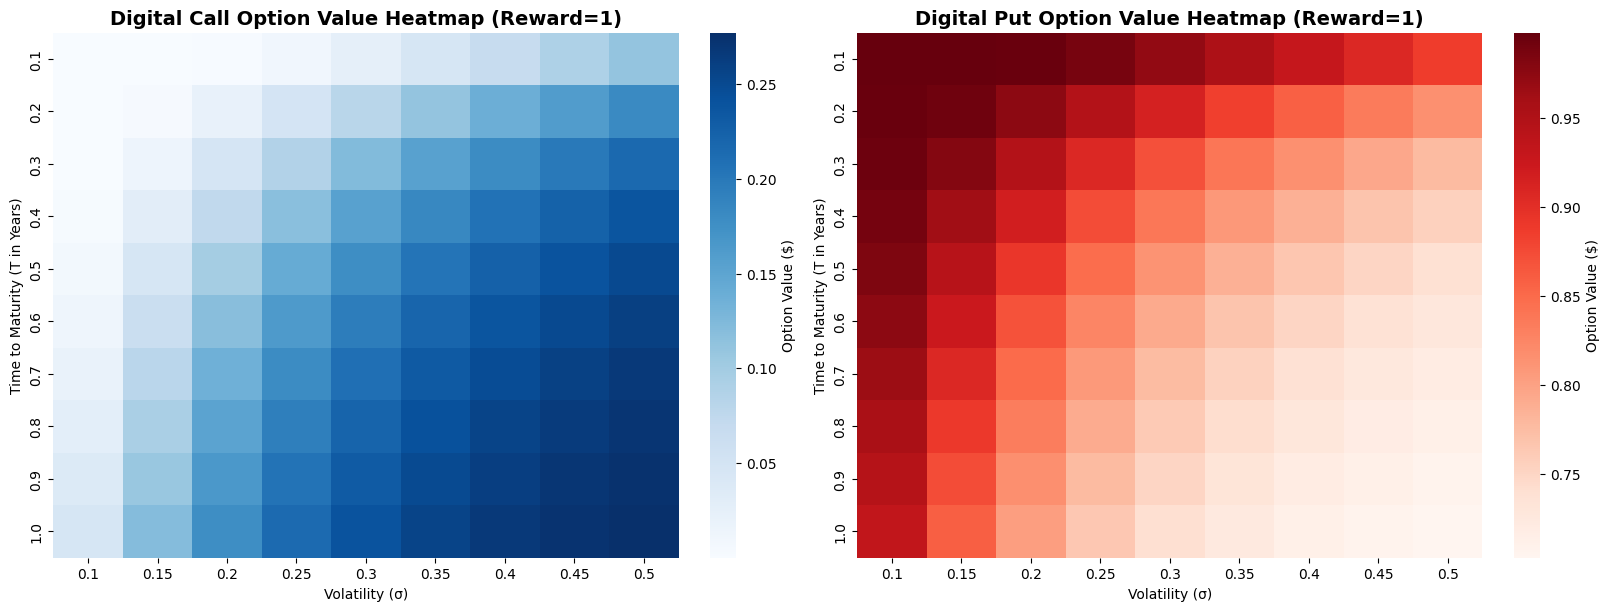

In [78]:
# Scenario 3: High Risk Investor

# Selected Product: Digital Options

# Parameters:
S_0 = (coffee_data['Close'].iloc[-1]).iloc[0] # Initial price, here spot price
S_x = S_0 * (1 + .05) # Strike price of coffee
r = 0.02 # Risk-free rate (2%)
T = .5 # Time to maturity (6 months)
daily_returns = coffee_data['Close'].pct_change() # Daily returns of coffee
sigma = (daily_returns.std() * np.sqrt(252)).iloc[0] # Annualized volatility of coffee

# Define the reward (price paid if the option is exercised)
reward = 1 # Reward for the option

# Calculate d1 and d2
def options_parameters(S_0, S_x, r, T, sigma):
    d1 = (np.log(S_0 / S_x) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

# Defining the strategy
call_strat = True # True for call option, False for put option

# Option pricing using Black-Scholes formula
def digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, call_strat=True, reward=1):
    if call_strat:
        return reward * np.exp(-r * T) * norm.cdf(d2)  # Multiply call price by reward
    else:
        return reward * np.exp(-r * T) * norm.cdf(-d2)  # Multiply put price by reward

d1, d2 = options_parameters(S_0, S_x, r, T, sigma)
V_call = digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, call_strat, reward)
V_put = digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, not call_strat, reward)

# Display results
print(f"Digital Call Option Value: ${V_call:.2f}")
print(f"Digital Put Option Value: ${V_put:.2f}")
print(f'Parameters:')
print(f'  Initial Price: ${S_0:.2f}')
print(f'  Strike Price: ${S_x:.2f}')
print(f'  Reward: ${reward:.2f}')
print(f'  Risk-free Rate: {r:.2%}')
print(f'  Time to Maturity: {T:.1f} years')
print(f'  Volatility: {sigma:.2%}')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Payoff Diagram
S_T = np.linspace(S_x * 0.8, S_x * 1.2, 500)  # Asset price range
digital_call_payoff = np.where(S_T > S_x, reward, 0) - V_call
digital_put_payoff = np.where(S_T < S_x, reward, 0) - V_put

axes[0].plot(S_T, digital_call_payoff, label='Digital Call Payoff', color='blue')
axes[0].plot(S_T, digital_put_payoff, label='Digital Put Payoff', color='red')
axes[0].axvline(S_x, color='black', linestyle='--', label='Strike Price')
axes[0].set_title('Digital Option Payoff Diagram (Reward=1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Asset Price at Maturity ($)')
axes[0].set_ylabel('Payoff ($)')
axes[0].legend()
axes[0].grid()

# Option Value vs. Strike Price
strike_prices = np.linspace(S_0 * 0.8, S_0 * 1.2, 500)
call_values = []
put_values = []

for S_x in strike_prices:
    d1, d2 = options_parameters(S_0, S_x, r, T, sigma)
    call_values.append(digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, call_strat=True, reward=reward))
    put_values.append(digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, call_strat=False, reward=reward))

axes[1].plot(strike_prices, call_values, label='Digital Call Option Value', color='blue')
axes[1].plot(strike_prices, put_values, label='Digital Put Option Value', color='red')
axes[1].axvline(S_0, color='black', linestyle='--', label='Current Price')
axes[1].set_title('Option Value vs. Strike Price (Reward=1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Strike Price ($)')
axes[1].set_ylabel('Option Value ($)')
axes[1].legend()
axes[1].grid()

plt.show()

# Define ranges for T and sigma
T_range = np.linspace(0.1, 1, 10)  # Time to maturity (0.01 to 1 year)
sigma_range = np.linspace(0.1, 0.5, 9)  # Volatility (10% to 50%)

# Create a grid of option values
call_values = np.zeros((len(T_range), len(sigma_range)))
put_values = np.zeros((len(T_range), len(sigma_range)))

for i, T in enumerate(T_range):
    for j, sigma in enumerate(sigma_range):
        d1, d2 = options_parameters(S_0, S_x, r, T, sigma)
        call_values[i, j] = digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, call_strat=True, reward=reward)
        put_values[i, j] = digital_option_pricer(S_0, S_x, r, T, sigma, d1, d2, call_strat=False, reward=reward)

# Plot heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Heatmap for Digital Call Option
sns.heatmap(call_values, ax=axes[0], 
            xticklabels=np.round(sigma_range, 2), 
            yticklabels=np.round(T_range, 2), 
            cmap='Blues', cbar_kws={'label': 'Option Value ($)'})
axes[0].set_title('Digital Call Option Value Heatmap (Reward=1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Volatility (σ)')
axes[0].set_ylabel('Time to Maturity (T in Years)')

# Heatmap for Digital Put Option
sns.heatmap(put_values, ax=axes[1], 
            xticklabels=np.round(sigma_range, 2), 
            yticklabels=np.round(T_range, 2), 
            cmap='Reds', cbar_kws={'label': 'Option Value ($)'})
axes[1].set_title('Digital Put Option Value Heatmap (Reward=1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Volatility (σ)')
axes[1].set_ylabel('Time to Maturity (T in Years)')

plt.show()

In [166]:
# Scenario 4: Diversification Seeker

# Product selected: Exchange Traded Fund (ETFs)

from sklearn.linear_model import LinearRegression

# Parameters
np.random.seed(42)
num_assets = 7  # Number of assets in the ETF
volatility = 0.02  # Volatility of the ETF

def generate_etf_portfolio(underlying, num_assets, volatility):
    # Ensure coffee_data['Close'] is one-dimensional
    underlying_close = underlying['Close'].values.flatten()
    portfolio_weights = np.random.random(num_assets)
    portfolio_weights /= portfolio_weights.sum()  # Normalize weights to sum to 1

    # Simulating ETF asset prices
    etf_assets = pd.DataFrame({
        f'Asset_{i+1}': underlying_close * (1 + np.random.normal(0, volatility, len(underlying_close)))
        for i in range(num_assets)
    }, index=underlying.index)

    # Drop any NaN values
    etf_assets = etf_assets.dropna()

    # ETF Portfolio Price: Weighted sum of assets
    etf_price = etf_assets.dot(portfolio_weights)
    etf_assets['Underlying_Price'] = underlying_close
    etf_assets['ETF_Price'] = etf_price
    
    return etf_assets

etf_portfolio = generate_etf_portfolio(coffee_data, num_assets, volatility)
etf_portfolio.head()

,Asset_1,Asset_2,Asset_3,Asset_4,Asset_5,Asset_6,Asset_7,Underlying_Price,ETF_Price
Date,,,,,,,,,
2010-01-04 00:00:00+00:00,142.641646,142.994647,143.676397,146.241893,138.927681,135.733744,143.666456,141.850006,143.187196
2010-01-05 00:00:00+00:00,143.849653,139.450805,142.584673,140.808175,144.598599,141.750640,143.149632,141.000000,141.476868
2010-01-06 00:00:00+00:00,139.954959,145.323463,137.482848,142.562454,142.876227,139.351215,141.587596,141.600006,141.710331
2010-01-07 00:00:00+00:00,140.409562,140.295073,141.809100,138.883363,141.564723,147.711561,146.336024,141.899994,140.959946
2010-01-08 00:00:00+00:00,143.689004,148.830227,147.937994,146.882838,145.076712,144.747178,146.993996,145.350006,147.153517


In [167]:
# Tracking Error Calculation
coffee_prices = coffee_data['Close']
def compute_tracking_error(etf_portfolio, underlying_prices, optimized):
    aligned_prices = underlying_prices.reindex(etf_portfolio.index)['KC=F']
    if optimized:
        squared_diff = (etf_portfolio['Optimized_ETF_Price'] - aligned_prices) ** 2
    else:
        squared_diff = (etf_portfolio['ETF_Price'] - aligned_prices) ** 2
    return np.sqrt(squared_diff.mean())  # Mean of squared differences, then sqrt

tracking_error = compute_tracking_error(etf_portfolio, coffee_prices, optimized=False)

# Optimize Portfolio Weights (Linear Regression for Best Fit)
X = etf_portfolio.drop(columns=['Underlying_Price','ETF_Price']).values  # Asset prices
y = coffee_prices.values.flatten()  # Benchmark prices

reg = LinearRegression(fit_intercept=False)  # No intercept, weights must sum to 1
reg.fit(X, y)
optimized_weights = reg.coef_
optimized_weights /= optimized_weights.sum()  # Normalize weights to sum to 1

# Optimized ETF Portfolio Price
etf_portfolio['Optimized_ETF_Price'] = etf_portfolio.drop(columns=['Underlying_Price','ETF_Price']).dot(optimized_weights)

# Recalculate Tracking Error for Optimized Portfolio
optimized_tracking_error = compute_tracking_error(etf_portfolio, coffee_prices, optimized=True)
etf_portfolio[['Underlying_Price', 'ETF_Price', 'Optimized_ETF_Price']].head()

,Underlying_Price,ETF_Price,Optimized_ETF_Price
Date,,,
2010-01-04 00:00:00+00:00,141.850006,143.187196,141.965453
2010-01-05 00:00:00+00:00,141.000000,141.476868,142.295766
2010-01-06 00:00:00+00:00,141.600006,141.710331,141.288945
2010-01-07 00:00:00+00:00,141.899994,140.959946,142.438241
2010-01-08 00:00:00+00:00,145.350006,147.153517,146.273675


In [168]:
# Computing returns of the ETF
etf_portfolio['ETF_Return'] = (etf_portfolio['ETF_Price'] - etf_portfolio['Underlying_Price']) / etf_portfolio['Underlying_Price']
etf_portfolio['Optimized_ETF_Return'] = (etf_portfolio['Optimized_ETF_Price'] - etf_portfolio['Underlying_Price']) / etf_portfolio['Underlying_Price']
etf_portfolio[['Underlying_Price', 'ETF_Price', 'Optimized_ETF_Price', 'ETF_Return', 'Optimized_ETF_Return']].tail()

,Underlying_Price,ETF_Price,Optimized_ETF_Price,ETF_Return,Optimized_ETF_Return
Date,,,,,
2025-01-20 00:00:00+00:00,328.350006,326.344388,326.518793,-0.006108,-0.005577
2025-01-21 00:00:00+00:00,327.799988,328.259761,329.503031,0.001403,0.005195
2025-01-22 00:00:00+00:00,341.850006,343.822327,343.287762,0.005770,0.004206
2025-01-23 00:00:00+00:00,343.950012,347.722026,346.072865,0.010967,0.006172
2025-01-24 00:00:00+00:00,346.649994,343.221505,347.315802,-0.009890,0.001921


Initial Portfolio Tracking Error: $1.58
Optimized Portfolio Tracking Error: $1.27
Optimized Portfolio Weights: [0.14719141 0.13888204 0.13697799 0.15055782 0.1366754  0.15105778
 0.13865756]


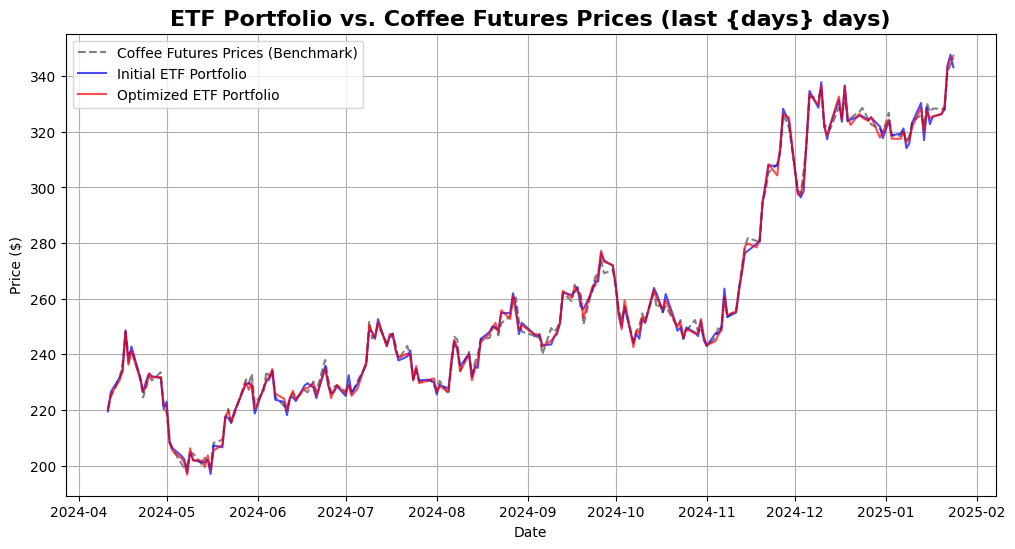

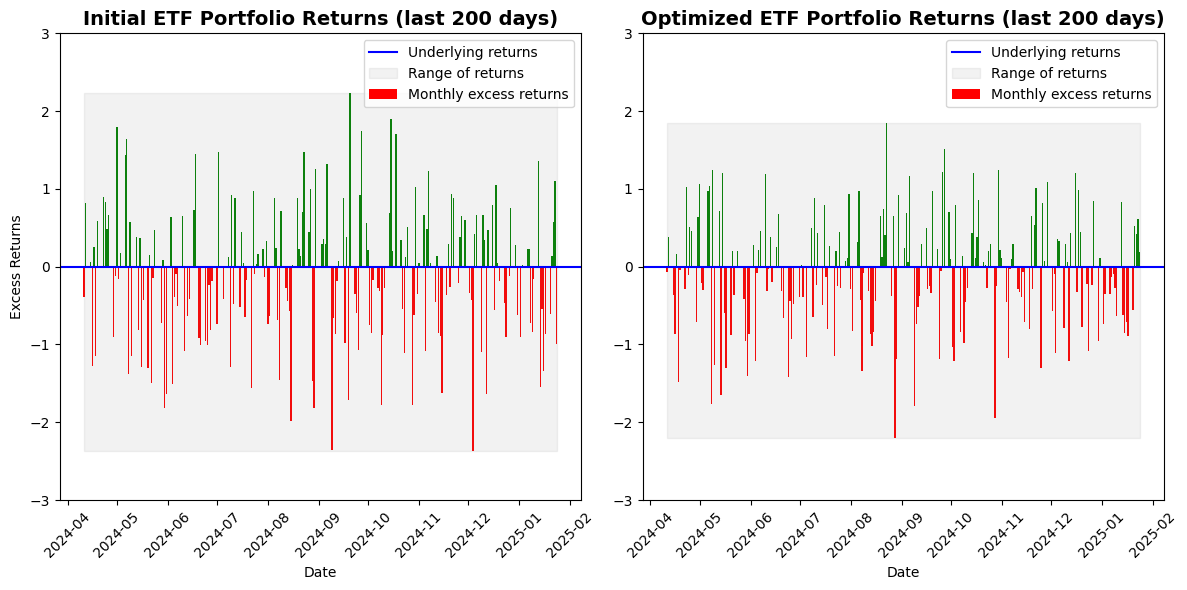

In [171]:
# Display Results
print(f"Initial Portfolio Tracking Error: ${tracking_error:.2f}")
print(f"Optimized Portfolio Tracking Error: ${optimized_tracking_error:.2f}")
print("Optimized Portfolio Weights:", optimized_weights)

days = 200  # Last 300 days

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(coffee_prices[-days:], label='Coffee Futures Prices (Benchmark)', color='grey', linestyle='--')
plt.plot(etf_portfolio['ETF_Price'][-days:], label='Initial ETF Portfolio', color='blue', alpha=0.7)
plt.plot(etf_portfolio['Optimized_ETF_Price'][-days:], label='Optimized ETF Portfolio', color='red', alpha=0.7)
plt.title('ETF Portfolio vs. Coffee Futures Prices (last {days} days)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Initial ETF Portfolio
lims = 3  # Adjust the limit as needed
returns = etf_portfolio['ETF_Return'][-days:] * 100
colors = ['green' if r > 0 else 'red' for r in returns]
axs[0].bar(etf_portfolio.index[-days:], returns, color=colors, label='Monthly excess returns')
axs[0].axhline(y=0, color='blue', linestyle='-', label='Underlying returns')  # Add horizontal line
axs[0].fill_between(
    etf_portfolio.index[-days:], 
    returns.max(), returns.min(), 
    color='gray', alpha=0.1, label='Range of returns')
axs[0].set_title(f"Initial ETF Portfolio Returns (last {days} days)", fontsize=14, fontweight='bold')
axs[0].set_ylim(-lims, lims)
axs[0].set_xlabel("Date")
axs[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for the first subplot
axs[0].set_ylabel("Excess Returns")
axs[0].legend(loc='upper right')

# Plot for Optimized ETF Portfolio
optimized_returns = etf_portfolio['Optimized_ETF_Return'][-days:] * 100
optimized_colors = ['green' if r > 0 else 'red' for r in optimized_returns]

axs[1].bar(etf_portfolio.index[-days:], optimized_returns, color=optimized_colors, label='Monthly excess returns')
axs[1].axhline(y=0, color='blue', linestyle='-', label='Underlying returns')  # Add horizontal line
axs[1].fill_between(
    etf_portfolio.index[-days:], 
    optimized_returns.max(), optimized_returns.min(), 
    color='gray', alpha=0.1, label='Range of returns'
)
axs[1].set_title(f"Optimized ETF Portfolio Returns (last {days} days)", fontsize=14, fontweight='bold')
axs[1].set_ylim(-lims, lims)
axs[1].set_xlabel("Date")
axs[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for the second subplot
axs[1].legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()
